In [33]:
# !pip install seaborn


In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats

In [35]:
# Set up files
dir_firstSess = 'data/corr_firstSess'
files_firstSess = [f for f in os.listdir(dir_firstSess) if f.endswith('.csv')]

dir_secondSess = 'data/corr_secondSess'
files_secondSess = [f for f in os.listdir(dir_secondSess) if f.endswith('.csv')]

numTotalSessions = len(files_firstSess) + len(files_secondSess)

print('Number of total sessions: ', numTotalSessions)
print('Number of subjects who completed the second session: ', len(files_secondSess))

Number of total sessions:  10
Number of subjects who completed the second session:  5


In [36]:
print('------first session------')
for f in files_firstSess:
    print(f)
    
print('------second session------')
for f in files_secondSess:
    print(f)


------first session------
NiceGrayDove270_63b2d04ed0f53f75de4ba38e_CrowdingReadingAcuity_firstSess16_0001_2025-06-04_21h32.33.098_UTC1.csv
LuckySilverGrape172_6684b71a5615b7da8e59ce56_CrowdingReadingAcuity_firstSess16_0001_2025-06-04_17h28.44.909_CDT.csv
GreatBrownBat682_6796a57996ad2f5398d6af0b_CrowdingReadingAcuity_firstSess16_0001_2025-06-04_23h17.47.539_UTC1.csv
WiseBronzeDove315_652017ac82f79ddfd3f25ef5_CrowdingReadingAcuity_firstSess16_0001_2025-06-04_16h27.57.888_EDT.csv
NiceSkySheep315_6566157a181e858a402fd981_CrowdingReadingAcuity_firstSess16_0001_2025-06-04_19h26.11.385_EDT.csv
------second session------
LoudNavyFish521_6796a57996ad2f5398d6af0b_CrowdingReadingAcuity_secondSess9_0001_2025-06-06_20h41.46.689_UTC1.csv
AlertNavyPlum863_652017ac82f79ddfd3f25ef5_CrowdingReadingAcuity_secondSess9_0001_2025-06-06_12h59.05.041_EDT.csv
KindPurpleBean372_63b2d04ed0f53f75de4ba38e_CrowdingReadingAcuity_secondSess9_0001_2025-06-06_17h26.51.372_UTC1.csv
GrandSilverLime351_6684b71a5615b7da8e

# Data cleaning
## Check if all experiments are completed

In [37]:
def checkIfComplete(mydir, files):
    
    numSess = len(files)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)

        # Exclusion criteria 1: experiment completed
        complete_val = mainOutput['experimentCompleteBool'].dropna().iloc[0]
        complete_bool = str(complete_val) == 'True'
        if not complete_bool:
            prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
            print(f'Warning: incomplete experiment (session: {sess})')
            
    print(f'Completion check completed! ({numSess} files total)')
                        

In [38]:
checkIfComplete(dir_firstSess, files_firstSess)

Completion check completed! (5 files total)


In [39]:
checkIfComplete(dir_secondSess, files_secondSess)

Completion check completed! (5 files total)


## Acquire thresholds for all tasks

### Functions:

In [40]:
def getThresholds(mydir, files, condition_names, num_trials_per_staircase=35):
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_logThresholds = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_logThresholds['prolificID'] = prolificID
                
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]
                        
            condition_data = mainOutput[mainOutput['conditionName'] == condition_name]
                        
            # number of trials sent to quest
            # Count trials sent to quest
            trial_sent = condition_data['trialGivenToQuest']           
            num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
            num_trial_not_sent = sum(str(this_trial) == 'False' for this_trial in trial_sent)
            trial_sent_bool = num_trial_sent >= num_trials_per_staircase
            num_missing_line = sum(trial_sent.isna())

            if not trial_sent_bool:
                # print(files[sess])
                print(f'Warning1: not enough trials (Session {sess}, condition {condition_name})')
                print(f'Num total trials: {len(trial_sent) - 1}')
                print(f'Num trials missing: {num_trials_per_staircase - num_trial_sent}')
                print(f'Num trials marked as not sent: {num_trial_not_sent}')
                print(f'Num lines missing: {num_missing_line - 1}')


            # questSD > 0.1
            questSD = condition_data['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
            small_questSD_bool = questSD < 0.1
            if not small_questSD_bool:
                print(f'Warning2: large SD (Session {sess}, condition {condition_name}, SD = {questSD})')
                
                
            assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)

            subj_logThresholds[condition_name] = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
#             if not small_questSD_bool:
#                 print(f'Warning: large SD (Session {sess}, condition {condition_name})')
            
#             if trial_sent_bool and small_questSD_bool:
#                 # check that only 1 threshold is reported for this condition
#                 assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)

#                 subj_logThresholds[condition_name] = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
                
#             else:
#                 subj_logThresholds[condition_name] = np.nan
            
        
        all_data.append(subj_logThresholds)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            


In [41]:
def getRSVPThresholds(mydir, files, condition_names, num_trials_per_staircase=24):
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_wpm = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_wpm['prolificID'] = prolificID
                
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]
                        
            condition_data = mainOutput[mainOutput['conditionName'] == condition_name]
                        
            # number of trials sent to quest
            # Count trials sent to quest
            trial_sent = condition_data['trialGivenToQuest']           
            num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
            num_trial_not_sent = sum(str(this_trial) == 'False' for this_trial in trial_sent)
            trial_sent_bool = num_trial_sent >= num_trials_per_staircase
            num_missing_line = sum(trial_sent.isna())

            if not trial_sent_bool:
                # print(files[sess])
                print(f'Warning1: not enough trials (Session {sess}, condition {condition_name})')
                print(f'Num total trials: {len(trial_sent) - 1}')
                print(f'Num trials missing: {num_trials_per_staircase - num_trial_sent}')
                print(f'Num trials marked as not sent: {num_trial_not_sent}')
                print(f'Num lines missing: {num_missing_line - 1}')

            # questSD > 0.1
            questSD = condition_data['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
            small_questSD_bool = questSD < 0.1
            if not small_questSD_bool:
                print(f'Warning2: large SD (Session {sess}, condition {condition_name}, SD = {questSD})')
            
#             if trial_sent_bool and small_questSD_bool:
#                 # check that only 1 threshold is reported for this condition
#                 assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)

#                 thresholds_raw_log = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
                
#                 subj_wpm[condition_name] = np.power(10, np.log10(60) - thresholds_raw_log)
                
#             else:
#                 subj_wpm[condition_name] = np.nan

            assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)

            thresholds_raw_log = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
            subj_wpm[condition_name] = np.power(10, np.log10(60) - thresholds_raw_log)

            
        
        all_data.append(subj_wpm)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
        

In [42]:
def getOrdReadingSpeed(mydir, files, condition_dict):
    
    condition_names = list(condition_dict.keys())
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):
        
        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_wpm = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_wpm['prolificID'] = prolificID
        
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]

            # Check if the participant answered 3 or more questions correctly
            question_labels = condition_dict[condition_name]
            num_questions = len(question_labels)
            question_correct_bool = np.full(num_questions,np.nan)
            for qq in range(num_questions):

                qq_data = mainOutput[mainOutput['questionAndAnswerNickname'] == question_labels[qq]]
                
                question_correct_bool[qq] = (qq_data['questionAndAnswerCorrectAnswer'].item() == qq_data['questionAndAnswerResponse'].item())
                
            percent_correct = sum(question_correct_bool) / num_questions * 100 
            
            
            if percent_correct >= 0: #60
            
                speed_data = mainOutput[mainOutput['conditionName'] == condition_name]
                
                numWords = speed_data['readingPageWords'].dropna()
                reading_time = speed_data['readingPageDurationOnsetToOffsetSec'].dropna()
                pg_wordsPerMin = numWords / (reading_time / 60)
                include_wordsPerMin = pg_wordsPerMin[1:len(pg_wordsPerMin)-1] # exclude first and last page
                subj_wpm[condition_name] = np.mean(include_wordsPerMin)
            
            else:
                
                print(f'Warning: percent correct is too low: session {sess}, passage {cat}')
                subj_wpm[condition_name] = np.nan
                
                
    
                
        all_data.append(subj_wpm)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            
        

### Acquire thresholds:

- Note that data acquired for RSVP and Ordinary reading are in words per min -- not logged

- All the other thresholds are logged

- As of March 16th, I'm not excluding any data, as we only have a few participants and somehow excluding data based on our exclusion criteria excludes too much data. The codes are ready for excluding data based on our pre-determined exclusion criteria; we can exclude data once we get more participants.

In [43]:
# first session

thresholds_names_sess1 = ['crowding_R8_block1','crowding_L8_block1',
                          'crowding_R8_block2','crowding_L8_block2',
                          'vernier_R8_block1','vernier_L8_block1',
                          'acuity_R8_block1','acuity_L8_block1']
df_firstSess = getThresholds(dir_firstSess, files_firstSess, thresholds_names_sess1)

thresholds_rsvp_sess1 = ['rsvp_foveal_block1']
df_firstSess_rsvp = getRSVPThresholds(dir_firstSess, files_firstSess, thresholds_rsvp_sess1)

thresholds_names_read1 = {
        'reading_Beaver_block1': ['Beaver_1','Beaver_2','Beaver_3','Beaver_4','Beaver_5'],
        'reading_Winter_block2': ['Winter_1','Winter_2','Winter_3','Winter_4','Winter_5']}
df_firstSess_reading = getOrdReadingSpeed(dir_firstSess, files_firstSess, thresholds_names_read1)

Warning2: large SD (Session 0, condition vernier_R8_block1, SD = 0.53429861)
Warning1: not enough trials (Session 0, condition vernier_L8_block1)
Num total trials: 38
Num trials missing: 1
Num trials marked as not sent: 0
Num lines missing: 4
Warning2: large SD (Session 0, condition vernier_L8_block1, SD = 0.513991175)
Warning2: large SD (Session 1, condition vernier_R8_block1, SD = 0.20569717)
Warning2: large SD (Session 1, condition vernier_L8_block1, SD = 0.209488628)
Warning1: not enough trials (Session 2, condition crowding_R8_block1)
Num total trials: 36
Num trials missing: 6
Num trials marked as not sent: 0
Num lines missing: 7
Warning1: not enough trials (Session 2, condition crowding_L8_block1)
Num total trials: 36
Num trials missing: 5
Num trials marked as not sent: 0
Num lines missing: 6
Warning2: large SD (Session 2, condition crowding_L8_block1, SD = 0.122330234)
Warning1: not enough trials (Session 2, condition crowding_R8_block2)
Num total trials: 36
Num trials missing: 

In [44]:
# second session

thresholds_names_sess2 = ['crowding_R8_block3','crowding_L8_block3',
                          'crowding_R8_block4','crowding_L8_block4',
                          'vernier_R8_block2','vernier_L8_block2',
                          'acuity_R8_block2','acuity_L8_block2']
df_secondSess = getThresholds(dir_secondSess, files_secondSess, thresholds_names_sess2)

thresholds_rsvp_sess2 = ['rsvp_foveal_block2']
df_secondSess_rsvp = getRSVPThresholds(dir_secondSess, files_secondSess, thresholds_rsvp_sess2)

thresholds_names_read2 = {
        'reading_Desert_block1': ['Desert_1','Desert_2','Desert_3','Desert_4','Desert_5'],
        'reading_Islands_block2': ['Islands_1','Islands_2','Islands_3','Islands_4','Islands_5']}

df_secondSess_reading = getOrdReadingSpeed(dir_secondSess, files_secondSess, thresholds_names_read2)


Warning2: large SD (Session 1, condition vernier_R8_block2, SD = 0.225476681)
Warning2: large SD (Session 1, condition vernier_L8_block2, SD = 0.166091625)
Warning2: large SD (Session 2, condition vernier_R8_block2, SD = 0.273779772)
Warning2: large SD (Session 2, condition vernier_L8_block2, SD = 0.150459671)
Warning2: large SD (Session 3, condition vernier_R8_block2, SD = 0.195028022)
Warning2: large SD (Session 3, condition vernier_L8_block2, SD = 0.264959587)
Warning2: large SD (Session 4, condition vernier_R8_block2, SD = 0.384357335)
Warning2: large SD (Session 4, condition vernier_L8_block2, SD = 0.117634751)


In [45]:
# merge data frames

df_first_merge = pd.merge(df_firstSess, df_firstSess_rsvp, on="prolificID", how="inner")
df_first = pd.merge(df_first_merge, df_firstSess_reading, on="prolificID", how="inner")

df_second_merge = pd.merge(df_secondSess, df_secondSess_rsvp, on="prolificID", how="inner")
df_second = pd.merge(df_second_merge, df_secondSess_reading, on="prolificID", how="inner")


df_both_sessions = pd.merge(df_first, df_second, on="prolificID", how="inner")
display(df_both_sessions)

,prolificID,crowding_R8_block1,crowding_L8_block1,crowding_R8_block2,crowding_L8_block2,vernier_R8_block1,vernier_L8_block1,acuity_R8_block1,acuity_L8_block1,rsvp_foveal_block1,...,crowding_L8_block3,crowding_R8_block4,crowding_L8_block4,vernier_R8_block2,vernier_L8_block2,acuity_R8_block2,acuity_L8_block2,rsvp_foveal_block2,reading_Desert_block1,reading_Islands_block2
0,63b2d04ed0f53f75de4ba38e,0.140829,0.277894,0.355206,0.781399,1.613391,1.678937,-0.490252,-0.419758,1073.781656,...,0.528213,0.159747,0.805931,-0.613740,-0.112506,-0.473470,-0.385683,1121.877801,291.261201,310.406797
1,6684b71a5615b7da8e59ce56,0.411445,0.509446,0.497729,0.372701,-0.807853,-0.791410,-0.469819,-0.396605,1752.558532,...,0.077439,0.015161,0.460526,-0.686627,-1.650596,-0.544064,-0.511127,1699.845745,220.681336,222.098263
2,6796a57996ad2f5398d6af0b,0.603331,0.594017,0.179589,0.698407,1.329069,1.501678,-0.431237,-0.528094,472.345031,...,0.581012,0.505802,0.343336,-0.853609,-0.236434,-0.604193,-0.422627,661.190508,103.314029,111.872259
3,652017ac82f79ddfd3f25ef5,-0.012178,0.142054,-0.072611,-0.064543,-1.211721,-1.219282,-0.420035,-0.512795,2124.899833,...,-0.037510,0.379673,-0.173552,-1.057152,-1.170025,-0.495855,-0.561884,1792.764292,334.131446,292.671985
4,6566157a181e858a402fd981,0.257182,0.792435,0.199973,0.358114,-1.112118,-1.755361,-0.373103,-0.455051,1163.572663,...,0.584024,0.222781,0.445876,-1.586925,-1.620258,-0.469592,-0.497507,953.086011,934.971274,1405.638668


## Examine crowding thresholds

In [46]:
dfs = [df_first, df_second]

crowding_data = []

for df in dfs:
    crowding_columns = [col for col in df.columns if col.startswith("crowding")]
    crowding_values = df[crowding_columns].values.flatten()
    crowding_data.extend(crowding_values)

crowding_array = np.array(crowding_data)

eccentricity = 8
bouma = 10 ** crowding_array / eccentricity

print(bouma)

[0.17287758 0.23703052 0.28321515 0.75562887 0.3223701  0.40397667
 0.39322333 0.29485682 0.50146504 0.49082552 0.18901607 0.62419077
 0.12154354 0.17336615 0.10575465 0.10773753 0.22599154 0.77507788
 0.19809911 0.28511745 0.42066733 0.47634528 0.40060132 0.27557883
 0.14107962 0.11465684 0.29962822 0.08382196 0.45862275 0.42181573
 0.18057479 0.79954153 0.33007713 0.14939942 0.1294407  0.36094078
 0.34418462 0.47966085 0.20878122 0.34896795]


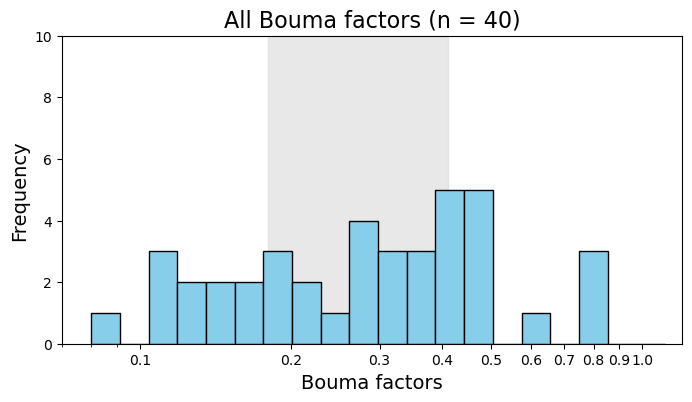

In [47]:
# Plot all bouma factors

# make the bins look the same size on a log scale
num_bins = 20
# min_val = round(np.nanmin(bouma),2)
# max_val = round(np.nanmax(bouma),2)
# print(f'Min and max bin limits: {min_val}, {max_val}')
# bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)
min_val = 0.08
max_val = 1.11
bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)
lowerBound = 0.18
upperBound = 0.41

plt.figure(figsize=(8, 4))  # Square figure
plt.axvspan(lowerBound, upperBound, color='lightgray', alpha=0.5) # mean +- one std
plt.hist(bouma, bins=bins, color='skyblue', edgecolor='black')
plt.title(f"All Bouma factors (n = {len(bouma)})", fontsize = 16)
plt.xlabel("Bouma factors", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)
plt.xscale('log')
plt.xlim(0.07,1.2)
plt.ylim(0,10)
# add ticks and format them as normal floats
tick_positions = np.linspace(0.1, 1, num=10)  
plt.xticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions])


plt.show()

# Analysis

### Test-retest

In [48]:
df_both_sessions['crowding_R8_12'] = (df_both_sessions['crowding_R8_block1'] + 
                                      df_both_sessions['crowding_R8_block2']) / 2

df_both_sessions['crowding_L8_12'] = (df_both_sessions['crowding_L8_block1'] + 
                                      df_both_sessions['crowding_L8_block2']) / 2

df_both_sessions['crowding_R8_34'] = (df_both_sessions['crowding_R8_block3'] + 
                                      df_both_sessions['crowding_R8_block4']) / 2

df_both_sessions['crowding_L8_34'] = (df_both_sessions['crowding_L8_block3'] + 
                                      df_both_sessions['crowding_L8_block4']) / 2

In [49]:
df_both_sessions['ordreading_sess1'] = 10 ** ((np.log10(df_both_sessions['reading_Beaver_block1']) + 
                                               np.log10(df_both_sessions['reading_Winter_block2'])) / 2)

df_both_sessions['ordreading_sess2'] = 10 ** ((np.log10(df_both_sessions['reading_Desert_block1']) + 
                                               np.log10(df_both_sessions['reading_Islands_block2'])) / 2)

In [50]:
def plot_scatter_with_correlation(df, var_x, var_y, title, plotXequalsY_bool=False):
    """
    Plots a scatter plot of two variables from a DataFrame and computes Pearson's r.
    
    Parameters:
        df (pd.DataFrame): The data frame containing the variables.
        var_x (str): Name of the first variable (x-axis).
        var_y (str): Name of the second variable (y-axis).
    """
    # Compute Pearson correlation
    r, p_value = stats.pearsonr(df[var_x], df[var_y])
    
    # Determine axis limits (same for both axes)
    min_val = min(df[var_x].min(), df[var_y].min())
    min_val = min_val - abs(min_val) * 0.2
    max_val = max(df[var_x].max(), df[var_y].max())
    max_val = max_val + abs(max_val) * 0.2


    # Create the scatter plot
    plt.figure(figsize=(4, 4))  
    sns.scatterplot(x=df[var_x], y=df[var_y], s=50)

    # plot x = y
    if plotXequalsY_bool:
            plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=1.5)
            
    # Set limits for both axes to be the same
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    # Add title with Pearson's r value
    plt.title(title + f"\n r = {r:.2f}", fontsize=16)
    
    # Add labels
    plt.xlabel(var_x, fontsize=14)
    plt.ylabel(var_y, fontsize=14)
    plt.xticks(fontsize=10)  
    plt.yticks(fontsize=10) 
    
        
    # Ensure aspect ratio is equal for x and y
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Show plot
    plt.show()


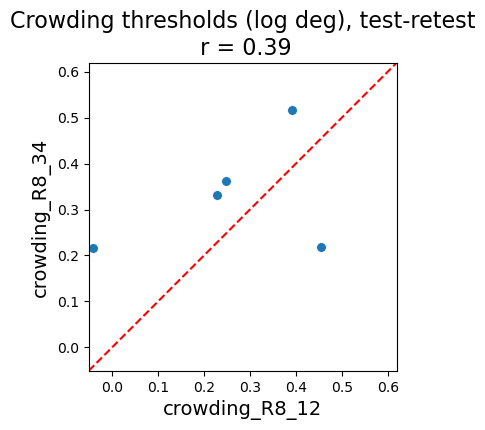

In [51]:
plot_scatter_with_correlation(df_both_sessions, "crowding_R8_12", "crowding_R8_34", 
                              'Crowding thresholds (log deg), test-retest', plotXequalsY_bool=True)


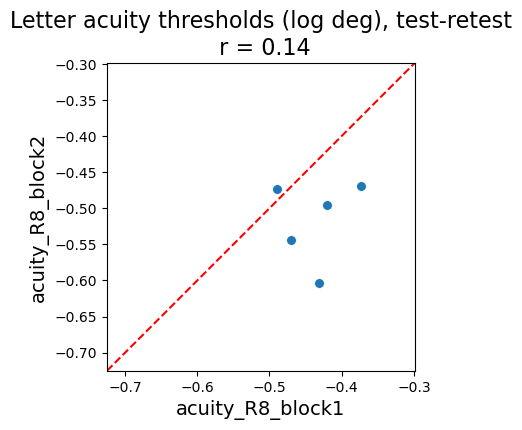

In [52]:
plot_scatter_with_correlation(df_both_sessions, "acuity_R8_block1", "acuity_R8_block2", 
                              'Letter acuity thresholds (log deg), test-retest', plotXequalsY_bool=True)


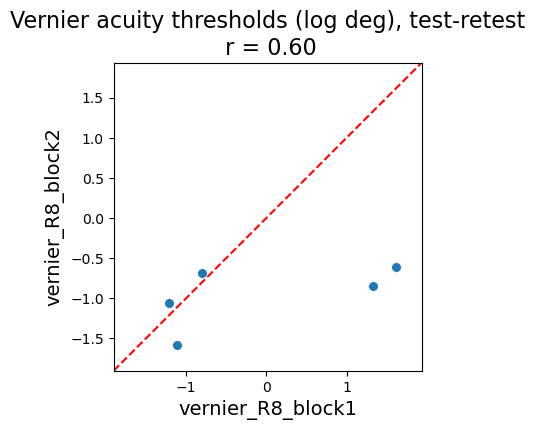

In [53]:
plot_scatter_with_correlation(df_both_sessions, "vernier_R8_block1", "vernier_R8_block2", 
                              'Vernier acuity thresholds (log deg), test-retest', plotXequalsY_bool=True)


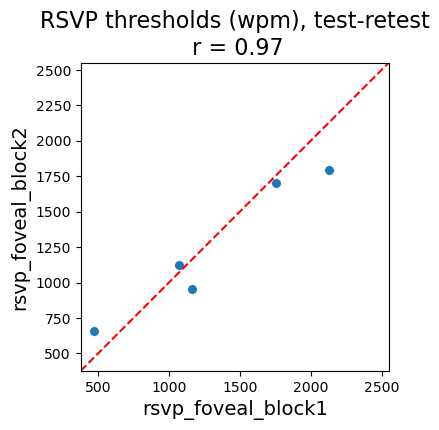

In [54]:
plot_scatter_with_correlation(df_both_sessions, "rsvp_foveal_block1", "rsvp_foveal_block2", 
                              'RSVP thresholds (wpm), test-retest', plotXequalsY_bool=True)


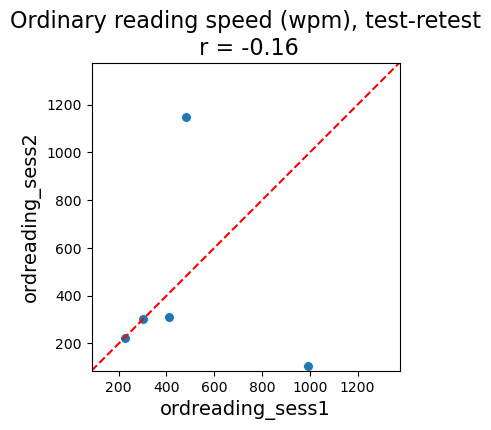

In [55]:
plot_scatter_with_correlation(df_both_sessions, "ordreading_sess1", "ordreading_sess2", 
                              'Ordinary reading speed (wpm), test-retest', plotXequalsY_bool=True)

### Average over repeats for each participant

In [56]:
# average between sessions

subj_avg_thresholds = {}


subj_avg_thresholds['crowding_R8'] = (df_both_sessions['crowding_R8_12'] + 
                                      df_both_sessions['crowding_R8_34']) / 2
subj_avg_thresholds['crowding_L8'] = (df_both_sessions['crowding_L8_12'] + 
                                      df_both_sessions['crowding_L8_34']) / 2
subj_avg_thresholds['crowding_RL'] = (subj_avg_thresholds['crowding_R8'] + 
                                      subj_avg_thresholds['crowding_L8']) / 2

subj_avg_thresholds['acuity_R8'] = (df_both_sessions['acuity_R8_block1'] + 
                                      df_both_sessions['acuity_R8_block2']) / 2
subj_avg_thresholds['acuity_L8'] = (df_both_sessions['acuity_L8_block1'] + 
                                      df_both_sessions['acuity_L8_block2']) / 2
subj_avg_thresholds['acuity_RL'] = (subj_avg_thresholds['acuity_R8'] + 
                                      subj_avg_thresholds['acuity_L8']) / 2

subj_avg_thresholds['vernier_R8'] = (df_both_sessions['vernier_R8_block1'] + 
                                      df_both_sessions['vernier_R8_block2']) / 2
subj_avg_thresholds['vernier_L8'] = (df_both_sessions['vernier_L8_block1'] + 
                                      df_both_sessions['vernier_L8_block2']) / 2
subj_avg_thresholds['vernier_RL'] = (subj_avg_thresholds['vernier_R8'] + 
                                      subj_avg_thresholds['vernier_L8']) / 2

subj_avg_thresholds['rsvp_log'] =  ((np.log10(df_both_sessions['rsvp_foveal_block1']) + 
                                      np.log10(df_both_sessions['rsvp_foveal_block2'])) / 2)

subj_avg_thresholds['ordinary_reading_log'] = ((np.log10(df_both_sessions['ordreading_sess1']) + 
                                               np.log10(df_both_sessions['ordreading_sess2'])) / 2)

df_subj_avg = pd.DataFrame(subj_avg_thresholds)
df_subj_avg.head()

,crowding_R8,crowding_L8,crowding_RL,acuity_R8,acuity_L8,acuity_RL,vernier_R8,vernier_L8,vernier_RL,rsvp_log,ordinary_reading_log
0,0.305082,0.598359,0.451721,-0.481861,-0.402721,-0.442291,0.499826,0.783216,0.641521,3.040431,2.478245
1,0.336510,0.355028,0.345769,-0.506942,-0.453866,-0.480404,-0.747240,-1.221003,-0.984122,3.237041,2.349614
2,0.453938,0.554193,0.504065,-0.517715,-0.475360,-0.496538,0.237730,0.632622,0.435176,2.747293,2.514369
3,0.086860,-0.033388,0.026736,-0.457945,-0.537339,-0.497642,-1.134436,-1.194653,-1.164545,3.290431,2.554200
4,0.279954,0.545112,0.412533,-0.421348,-0.476279,-0.448813,-1.349521,-1.687809,-1.518665,3.022463,2.870141


### Is there left-right asymmetry?

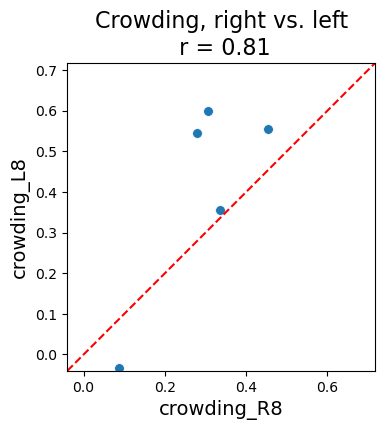

In [57]:
plot_scatter_with_correlation(df_subj_avg, "crowding_R8", "crowding_L8", 
                              'Crowding, right vs. left', plotXequalsY_bool=True)

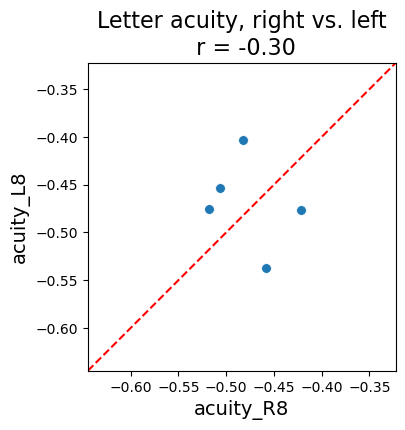

In [58]:
plot_scatter_with_correlation(df_subj_avg, "acuity_R8", "acuity_L8", 
                              'Letter acuity, right vs. left', plotXequalsY_bool=True)

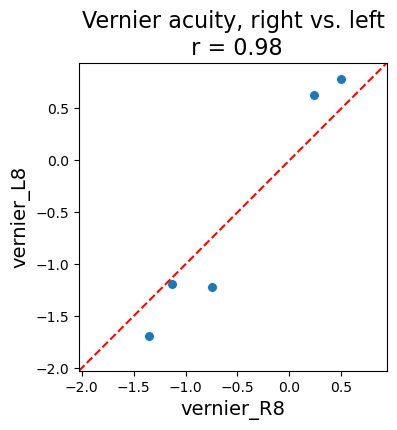

In [59]:
plot_scatter_with_correlation(df_subj_avg, "vernier_R8", "vernier_L8", 
                              'Vernier acuity, right vs. left', plotXequalsY_bool=True)

### Correlation between tasks

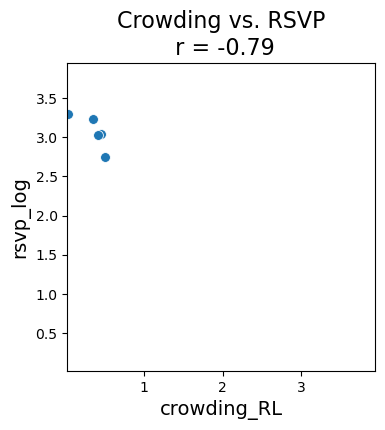

In [60]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "rsvp_log", 
                              'Crowding vs. RSVP')

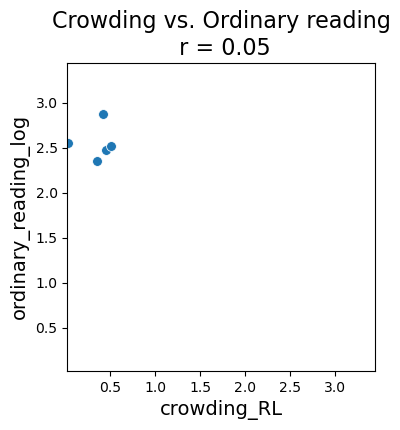

In [61]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "ordinary_reading_log", 
                              'Crowding vs. Ordinary reading')

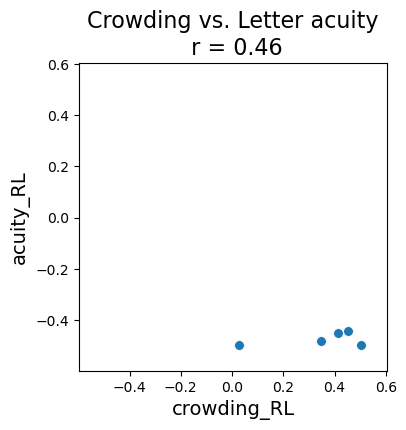

In [62]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "acuity_RL", 
                              'Crowding vs. Letter acuity')

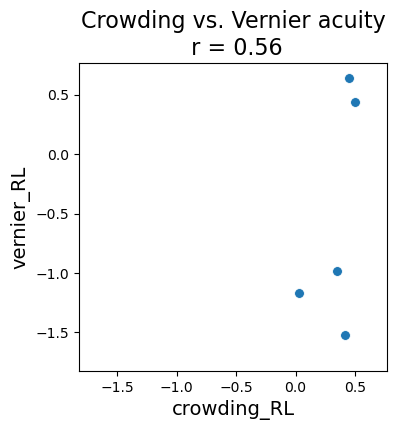

In [63]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "vernier_RL", 
                              'Crowding vs. Vernier acuity')

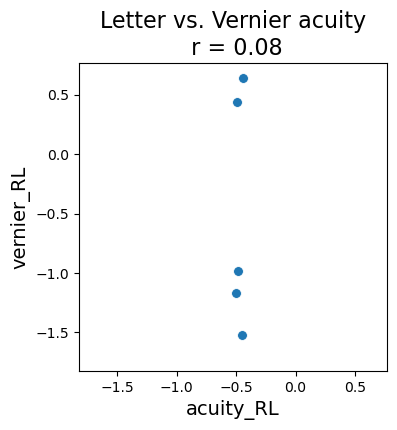

In [64]:
plot_scatter_with_correlation(df_subj_avg, "acuity_RL", "vernier_RL", 
                              'Letter vs. Vernier acuity')